Training set size: 63270
Validation set size: 7404
Test set size: 7571
Training set size after SMOTE: 109586

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      6393
           1       0.41      0.44      0.42      1011

    accuracy                           0.84      7404
   macro avg       0.66      0.67      0.66      7404
weighted avg       0.84      0.84      0.84      7404


Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      6572
           1       0.41      0.45      0.43       999

    accuracy                           0.84      7571
   macro avg       0.66      0.68      0.67      7571
weighted avg       0.85      0.84      0.85      7571



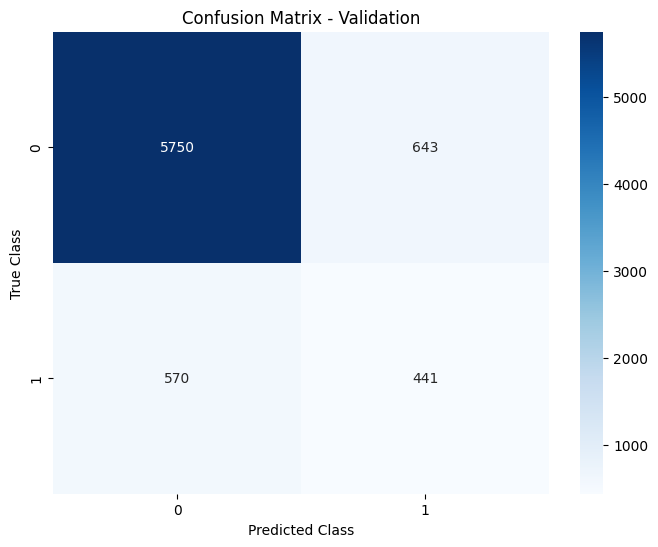

[[5936  636]
 [ 551  448]]


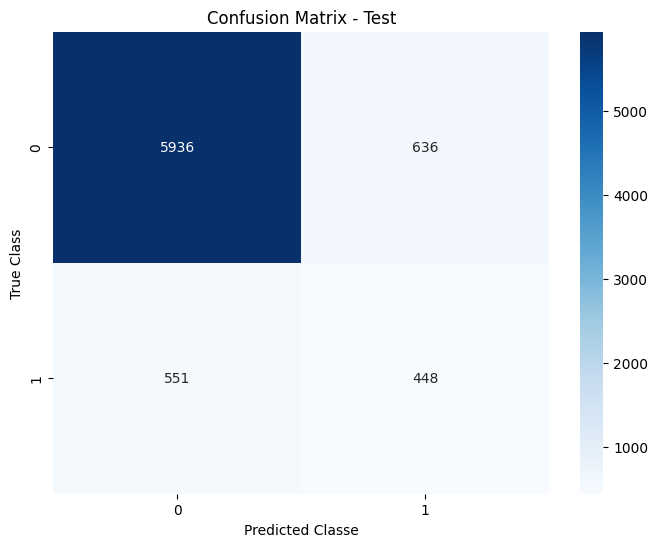

In [ ]:
#This script performs supervised classification to detect segmentation points in tokenized text
    #It includes the following steps:
        #- Data shuffling and sentence-level split into train, validation, and test sets
        #- Feature scaling using StandardScaler for numerical features
        #- Balancing the training set with SMOTE (Synthetic Minority Over-sampling Technique)
        #- Training a Decision Tree Classifier
        #- Evaluation on both validation and test sets with classification reports and confusion matrices

import pickle

# Load the preprocessed DataFrame from a pickle file
with open('/content/parole.pkl', 'rb') as file:
    df_caricato = pickle.load(file)

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

#Shuffle the full DataFrame to remove any ordering bias
df_caricato = shuffle(df_caricato, random_state=42)

#Get unique sentence indices and shuffle them
frasi_idx = df_caricato['frase_idx'].unique()
frasi_idx = shuffle(frasi_idx, random_state=42)

#Split sentence indices: 90% for training + validation, 10% for test
frasi_trainval, frasi_test = train_test_split(frasi_idx, test_size=0.1, random_state=42)

#From training+validation, split 10% for validation (i.e. 9% of total data)
frasi_train, frasi_val = train_test_split(frasi_trainval, test_size=0.1, random_state=42)

#Filter DataFrames by sentence indices
df_train = df_caricato[df_caricato['frase_idx'].isin(frasi_train)]
df_val   = df_caricato[df_caricato['frase_idx'].isin(frasi_val)]
df_test  = df_caricato[df_caricato['frase_idx'].isin(frasi_test)]

#Separate features (X) and labels (y)
X_train = df_train.drop(columns=['segmenta', 'frase_idx', 'token'])
y_train = df_train['segmenta']

X_val = df_val.drop(columns=['segmenta', 'frase_idx', 'token'])
y_val = df_val['segmenta']

X_test = df_test.drop(columns=['segmenta', 'frase_idx', 'token'])
y_test = df_test['segmenta']

# Print the size of each dataset
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

# 7. Define which columns are numerical and which are binary (for POS tags)
numerical_cols = ['frase_len_token', 'frase_len_char', 'token_len_char', 'distanza_da_prima_parola']
binary_cols = ['NOUN', 'VERB', 'ADJ', 'DET', 'ADP', 'PRON', 'PUNCT', 'ADV', 'NUM', 'CCONJ']

# Create a column transformer to scale only the numerical columns
preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), numerical_cols)
], remainder='passthrough')  # Keep other columns (binary) as they are

# Apply preprocessing: fit on training, transform all sets
X_train_scaled = preprocessor.fit_transform(X_train)
X_val_scaled = preprocessor.transform(X_val)
X_test_scaled = preprocessor.transform(X_test)

# Reconvert the results to DataFrames with column names and matching indices
X_train_scaled = pd.DataFrame(X_train_scaled, columns=numerical_cols + binary_cols, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=numerical_cols + binary_cols, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numerical_cols + binary_cols, index=X_test.index)

# 8. Apply SMOTE only on the training set to balance class distribution
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# Print size of the training set after applying SMOTE
print(f"Training set size after SMOTE: {len(X_train_res)}")

# 9. Train a Decision Tree classifier on the resampled training set
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_res, y_train_res)

# 10. Evaluate on the validation set
y_pred_val = clf.predict(X_val_scaled)

print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_pred_val))

# Predict on the test set
y_test_pred = clf.predict(X_test_scaled)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

# 11. Plot confusion matrix for the validation set
cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Validation')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

# Plot confusion matrix for the test set
cm = confusion_matrix(y_test, y_test_pred)
print(cm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title('Confusion Matrix - Test')
plt.xlabel('Predicted Classe')
plt.ylabel('True Class')
plt.show()
